In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from uncertainties import unumpy as unp
import uncertainties
import seaborn as sb
import matplotlib.cm as cm
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



from scipy.stats.mstats import gmean

1. Read the data

In [2]:
raw_data = pd.read_excel('data/RawData.xlsx')
#raw_data = raw_data[~raw_data.units.str('trap')]

2. Focus on the sites which have competing data: both population (number of individuals) and biomass

In [3]:
raw_data.loc[:,'norm value'] = raw_data.loc[:,'numerical value']
raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','norm value'] = raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','norm value']*0.3 #convert the wet mass to an effective dry mass, by multiplying by 0.3

def unit_type(x):
    X=x.partition('/')[0]#[str(xi).partition('/')[0] for xi in x]
    return X

raw_data.loc[:,'units type'] = raw_data.units.apply(unit_type) #units type distinguishes population to biomass measurements
raw_data.groupby('units type').site.nunique()


units type
individuals    444
mg             392
Name: site, dtype: int64

3. Remove partial measurements

In [4]:
metadata = pd.read_csv('data/groups_per_reference.csv')
data_with_meta = raw_data.merge(metadata,left_on='reference', right_on='Paper',how='left')

In [5]:
valid_data = data_with_meta.copy()
valid_data = valid_data[(valid_data['Standard groups']!='Microarthropods') | ((valid_data['Standard groups']=='Microarthropods') & (valid_data['sub-class'].isin(['Acari','Collembola'])))]

4. Classify into groups using "aggregated taxon" and "aggregated environment"

In [6]:
valid_data.loc[valid_data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
valid_data.loc[valid_data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
valid_data.loc[valid_data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
valid_data.loc[valid_data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
valid_data.loc[valid_data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

In [7]:
soil_data = valid_data[valid_data['aggregated environment'] =='soil/litter']
canopy_data = valid_data[valid_data['aggregated environment'] =='plants']
surface_data = valid_data[valid_data['aggregated environment'] =='above ground']

In [8]:
soil_data.groupby('aggregated biome').site.nunique()#.site.nunique()
#surface_data.site.nunique()


aggregated biome
Boreal Forests/Taiga                                            28
Crops                                                           35
Deserts and Xeric Shrublands                                    12
Mediterranean Forests, Woodlands and Scrub                      21
Pasture                                                         41
Shrubland/Grassland                                             13
Temperate Forests                                               97
Temperate Grasslands, Savannas and Shrublands                   38
Tropical and Subtropical Forests                                86
Tropical and Subtropical Grasslands, Savannas and Shrublands    27
Tundra                                                          65
Name: site, dtype: int64

5. Remove measurements with unknown biomes (ants)

In [9]:
soil_data = soil_data[soil_data['aggregated biome'] != 'Shrubland/Grassland']#Drop the ants measurements with unknown biomes

7. Calculate means

In [10]:
#Average the soil data over each taxon in each site, then sum all taxons in each site according to the aggregated groups and data type they are in.
soil_site_taxa_mean = soil_data.groupby(['units type','aggregated taxon','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
soil_site_data = soil_site_taxa_mean.groupby(['units type','aggregated taxon','aggregated biome','site'])['norm value'].sum().reset_index()
#soil_site_data = soil_site_taxa_mean.groupby(['units type','aggregated taxon','aggregated biome','site'])['norm value'].sum().reset_index()

#Divide into the two types of measurements
soil_site_data_pop = soil_site_data[soil_site_data['units type']=='individuals']
soil_site_data_pop.rename(columns={'norm value': 'population density'}, inplace=True)

soil_site_data_mass = soil_site_data[soil_site_data['units type']=='mg']
soil_site_data_mass.rename(columns={'norm value': 'mass density'}, inplace=True)

#Construct a new dataframe, where we keep only the sites with both measurement types
soil_site_data_comb = pd.merge( soil_site_data_pop, soil_site_data_mass, on=["aggregated taxon","aggregated biome","site"], how="inner", validate="one_to_one" )

#calculate the mass of an individual per site, in units of mg/ind
soil_site_data_comb.loc[:,'ind mass']=soil_site_data_comb.loc[:,'mass density']/soil_site_data_comb.loc[:,'population density']

soil_site_data_comb.pivot_table(index='aggregated taxon',columns='aggregated biome',values='ind mass', aggfunc=['mean','count'])
#soil_site_data_comb = soil_site_data_comb.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
#soil_site_data_comb.columns = soil_site_data_comb.columns.set_levels(['Mean','N'],1)

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


mean                                        \
aggregated biome Boreal Forests/Taiga     Crops   Pasture Temperate Forests   
aggregated taxon                                                              
Acari                        0.003206       NaN       NaN          0.015937   
Collembola                   0.004459       NaN       NaN          0.015480   
Formicidae                        NaN  0.343756  0.644897          2.278229   
Isoptera                          NaN  0.819060  0.672940          0.680539   
Other                        0.345232  2.514433  3.820162          3.269194   

                                                                \
aggregated biome Temperate Grasslands, Savannas and Shrublands   
aggregated taxon                                                 
Acari                                                 0.001764   
Collembola                                            0.002450   
Formicidae                                            0.548186   
Isoptera                                              0.289569   
Other                                                 3.153510   

                                                   \
aggregated biome Tropical and Subtropical Forests   
aggregated taxon                                    
Acari                                    0.001765   
Collembola                               0.008673   
Formicidae                               0.424516   
Isoptera                                 1.069180   
Other                                    4.044042   

                                                                               \
aggregated biome Tropical and Subtropical Grasslands, Savannas and Shrublands   
aggregated taxon                                                                
Acari                                                      0.002253             
Collembola                                                 0.004211             
Formicidae                                                 0.784287             
Isoptera                                                   1.665947             
Other                                                      3.133116             

                                          count                \
aggregated biome    Tundra Boreal Forests/Taiga Crops Pasture   
aggregated taxon                                                
Acari             0.005766                 17.0   NaN     NaN   
Collembola        0.006051                 17.0   NaN     NaN   
Formicidae             NaN                  NaN   6.0    10.0   
Isoptera               NaN                  0.0   9.0    16.0   
Other             1.242991                 15.0   7.0    11.0   

                                    \
aggregated biome Temperate Forests   
aggregated taxon                     
Acari                         13.0   
Collembola                    13.0   
Formicidae                     5.0   
Isoptera                       3.0   
Other                         14.0   

                                                                \
aggregated biome Temperate Grasslands, Savannas and Shrublands   
aggregated taxon                                                 
Acari                                                      3.0   
Collembola                                                 7.0   
Formicidae                                                 4.0   
Isoptera                                                   1.0   
Other                                                     11.0   

                                                   \
aggregated biome Tropical and Subtropical Forests   
aggregated taxon                                    
Acari                                         4.0   
Collembola                                    4.0   
Formicidae                                   10.0   
Isoptera                                     32.0   
Other                                        16.0   

                 

In [11]:
soil_site_data_mass.loc[soil_site_data_mass.loc[:,'aggregated taxon']== 'Isoptera'].loc[:,'aggregated biome'].unique()

array(['Boreal Forests/Taiga', 'Crops', 'Deserts and Xeric Shrublands',
       'Mediterranean Forests, Woodlands and Scrub', 'Pasture',
       'Temperate Forests',
       'Temperate Grasslands, Savannas and Shrublands',
       'Tropical and Subtropical Forests',
       'Tropical and Subtropical Grasslands, Savannas and Shrublands',
       'Tundra'], dtype=object)

In [12]:
def filter_outliers(x):
    if len(x)>3:
        STD=x.std()
        Mean=np.mean(x)
        x = x[x<(Mean+2*STD)]
        x = x[x>(Mean-2*STD)]
    return x

soil_ratio_filt = soil_site_data_comb.groupby(['aggregated taxon','aggregated biome'])['ind mass'].apply(filter_outliers)
soil_ratio_filt_full = soil_ratio_filt.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='ind mass', aggfunc='mean')
soil_ratio_filt_total = soil_ratio_filt.reset_index().groupby('aggregated taxon')['ind mass'].mean()
soil_ratio_filt_full = pd.merge(soil_ratio_filt_full, soil_ratio_filt_total,on="aggregated taxon", how="inner", validate="one_to_one" )

soil_ratio_filt_full.rename(columns={'ind mass': 'Total average (mg/ind)'}, inplace=True)

#fill in the nans with the global averages
for clm in soil_ratio_filt_full.columns:
    soil_ratio_filt_full.loc[soil_ratio_filt_full[clm].isnull(),clm] = soil_ratio_filt_full['Total average (mg/ind)']

biomes = soil_site_data_pop.loc[:,'aggregated biome'].unique()

for biom in biomes: 
    if biom not in soil_ratio_filt_full.columns:
        soil_ratio_filt_full.loc[:,biom] = soil_ratio_filt_full.loc[:,'Total average (mg/ind)']
        
soil_ratio_filt_full.to_csv('results/average_ind_mass_full.csv')##       

def print_ratio(x):
    return '{:.2e}'.format(x)

soil_ratio_filt_print = soil_ratio_filt_full.applymap(print_ratio)
#soil_ratio_filt_print.to_csv('results/table_average_ind_mass.csv')##

#soil_ratio_filt_pd = soil_ratio_filt.reset_index().groupby(["aggregated taxon","aggregated biome"]).mean()['ind mass'].reset_index()
#soil_ratio_filt_pd = soil_ratio_filt.reset_index().groupby(["aggregated taxon","aggregated biome"]).mean().drop(columns='level_2')
#soil_ratio_filt_pd.to_csv('results/pd_average_ind_mass.csv')##


#soil_ratio_filt_print
soil_ratio_filt_full.applymap(print_ratio)



,Boreal Forests/Taiga,Crops,Pasture,Temperate Forests,"Temperate Grasslands, Savannas and Shrublands",Tropical and Subtropical Forests,"Tropical and Subtropical Grasslands, Savannas and Shrublands",Tundra,Total average (mg/ind),Deserts and Xeric Shrublands,"Mediterranean Forests, Woodlands and Scrub"
aggregated taxon,,,,,,,,,,,
Acari,2.90e-03,4.72e-03,4.72e-03,8.40e-03,1.76e-03,1.77e-03,2.25e-03,4.95e-03,4.72e-03,4.72e-03,4.72e-03
Collembola,4.17e-03,5.58e-03,5.58e-03,9.67e-03,2.45e-03,8.67e-03,4.21e-03,5.12e-03,5.58e-03,5.58e-03,5.58e-03
Formicidae,6.98e-01,1.28e-01,6.45e-01,2.28e+00,5.48e-01,2.34e-01,7.84e-01,6.98e-01,6.98e-01,6.98e-01,6.98e-01
Isoptera,7.63e-01,8.19e-01,6.17e-01,6.81e-01,2.90e-01,7.95e-01,9.14e-01,7.63e-01,7.63e-01,7.63e-01,7.63e-01
Other,3.02e-01,2.51e+00,3.82e+00,1.52e+00,2.35e+00,2.62e+00,3.13e+00,2.87e-01,1.88e+00,1.88e+00,1.88e+00


In [13]:
#find the measurements where only population data is available
cond1 = soil_site_data_pop['site'].isin(soil_site_data_comb['site'])
cond2 = soil_site_data_pop['population density'].isin(soil_site_data_comb['population density'])
soil_site_data_pop_pure = soil_site_data_pop.drop(soil_site_data_pop[cond1 & cond2].index )#measurements with only population measurements, and no mass measurements, based on site name and numerical value

In [14]:
#convert population to effective mass
soil_site_data_pop_pure.loc[:,'eff. mass_B'] = np.nan # eff. mass_B will use taxon and biome level average mass of individual
soil_site_data_pop_pure.loc[:,'eff. mass_G'] = np.nan # eff. mass_G will use global average for each taxon
for ii in soil_site_data_pop_pure.index:
    if soil_site_data_pop_pure.loc[ii,'aggregated taxon'] != 'Other':
        soil_site_data_pop_pure.loc[ii,'eff. mass_B'] = soil_site_data_pop_pure.loc[ii,'population density']* soil_ratio_filt_full.loc[soil_site_data_pop_pure.loc[ii,'aggregated taxon'],soil_site_data_pop_pure.loc[ii,'aggregated biome']]
        soil_site_data_pop_pure.loc[ii,'eff. mass_G'] = soil_site_data_pop_pure.loc[ii,'population density']* soil_ratio_filt_full.loc[soil_site_data_pop_pure.loc[ii,'aggregated taxon'],'Total average (mg/ind)']

#contains all the measurements, converted into mass
soil_site_data_mass_all = pd.merge(soil_site_data_mass,soil_site_data_pop_pure,on=["aggregated taxon","aggregated biome","site"], how="outer")
#mass_B/G columns are a combination of the measured mass with the effective mass where no direct measurement is given (_B and _G are for biome level or global level)
indx_mass = ~np.isnan(soil_site_data_mass_all.loc[:,'mass density']) #index of the mass measurements

soil_site_data_mass_all.loc[:,'mass_B'] = np.nan
soil_site_data_mass_all.loc[:,'mass_G'] = np.nan
soil_site_data_mass_all.loc[indx_mass,'mass_B'] = soil_site_data_mass_all.loc[indx_mass,'mass density']
soil_site_data_mass_all.loc[~indx_mass,'mass_B'] = soil_site_data_mass_all.loc[~indx_mass,'eff. mass_B']
soil_site_data_mass_all.loc[indx_mass,'mass_G'] = soil_site_data_mass_all.loc[indx_mass,'mass density']
soil_site_data_mass_all.loc[~indx_mass,'mass_G'] = soil_site_data_mass_all.loc[~indx_mass,'eff. mass_G']

soil_site_data_mass_all = soil_site_data_mass_all[~np.isnan(soil_site_data_mass_all.loc[:,'mass_G'])] # remove measurements of "other" taxa, and where there is no direct biomass measurement
#indx_pop_other = np.isnan(soil_site_data_mass_all.loc[:,'mass_G']) #index of measurements of "other" taxa, and where there is no direct biomass measurement

#soil_site_data_mass_all.groupby(["aggregated biome","aggregated taxon"]).count()

In [15]:
def LogMean(x , kk = 1 , scale = 1): #returns the mean, lower, and upper standard errors based on a log transform with a shift parameter kk (default = 1). Scale changes the units used, such that the effect of kk can be reduced
    if kk == 0 or len(x) < 2:
        return  gmean(x), 0 , 0
    else:    
        Xlog = np.log10(scale*x + kk)                
        return ((10**np.mean(Xlog))-kk)/scale , ((10**(np.mean(Xlog)-Xlog.sem()))-kk)/scale ,((10**(np.mean(Xlog)+Xlog.sem()))-kk)/scale
    
def calc_uval(x):
    return unp.uarray(nominal_values=np.mean(x),std_devs=x.sem())

Scale = 1e1 #such that "kk=1" corresponds to 0.1mg, which is the "detection limit"

def calc_mean(x):
    return (LogMean(x,kk = 1,scale = Scale)[0]+np.mean(x))/2

def calc_min(x):    
    return np.nanmin( np.array([LogMean(x,kk = 1,scale = Scale)[0], np.mean(x)-x.sem()]) )
    
def calc_max(x):
    return np.nanmax( np.array([LogMean(x,kk = 1,scale = Scale)[2], np.mean(x)+x.sem(), np.mean(x)]) )

def calc_mean_log(x):
    return LogMean(x,kk = 1,scale = Scale)[0]

def calc_mean_ar(x):
    return np.mean(x)

def calc_mean_ar_sem(x):
    return x.sem()


soil_biome_means_B = soil_site_data_mass_all.reset_index().groupby(['aggregated taxon','aggregated biome'])['mass_B'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
soil_biome_means_G = soil_site_data_mass_all.reset_index().groupby(['aggregated taxon','aggregated biome'])['mass_G'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
soil_biome_means_B.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)
soil_biome_means_G.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)

##Make a copy in pivot tables that will be exported
#soil_biome_means_print1 = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc=[calc_mean,'count'])
#soil_biome_means_print2 = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc=[calc_uval,calc_mean_log,'count'])

#soil_biome_means_print1 = soil_biome_means_print1.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
#soil_biome_means_print1.columns = soil_biome_means_print1.columns.set_levels(['Mean','N'],1)
#soil_biome_means_print2 = soil_biome_means_print2.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
#soil_biome_means_print2.columns = soil_biome_means_print2.columns.set_levels(['G.Mean','A.Mean','N'],1)

#def print_u(x):
#    if type(x) != uncertainties.core.Variable:
#        if x<1000:
#            return '{:.0f}'.format(x)
#        else:
#            return '{:.2e}'.format(x)
#    else: 
#        return '{:.2e}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

#soil_biome_means_print1 = soil_biome_means_print1.applymap(print_u)
#soil_biome_means_print2 = soil_biome_means_print2.applymap(print_u)
#soil_biome_means_print_full = soil_biome_means.applymap(print_u)

##save to .csv files
#soil_biome_means_print1.to_csv('results/table_1pop.csv')
#soil_biome_means_print2.to_csv('results/table_1pop_means.csv')
#soil_biome_means_print_full.to_csv('results/table_1pop_full.csv')

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:324: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


8. Prepare plot and read data for termites

In [16]:
def legend_without_duplicate_labels(ax,pos):
    handles, labels = ax.get_legend_handles_labels()
    mapping = [ ['Acari', 'Acari (Mites & Ticks)'],['Collembola', 'Collembola (Springtails)'],['Formicidae','Formicidae (Ants)'],['Isoptera', 'Isoptera (Termites)'],['Other','Others']]
    labels2 = [x.replace(subM[0], subM[1]) for x in labels for subM in mapping if subM[0] in x]
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels2)) if l not in labels2[:i]]
    unique = [unique[0],unique[1],unique[2], unique[3], unique[4]]      ## can be removed
    ax.legend(*zip(*unique),bbox_to_anchor=pos,loc = 'lower left', ncol=5)


In [17]:
Isoptera_data = pd.read_excel('data/IsopteraData.xlsx')

In [18]:
#Get the aggregated biome areas for use in the plot below
biome_area = pd.read_csv('data/aggregated biomes data.csv') # biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum() #aggregate the biomes areas
biome_area1/1e12

aggregated biome 1
Boreal Forests/Taiga                                            15.700
Crops                                                           15.300
Deserts and Xeric Shrublands                                    19.600
Pasture                                                         27.600
Temperate Forests                                               10.760
Temperate Grasslands, Savannas and Shrublands                    5.430
Tropical and Subtropical Forests                                17.643
Tropical and Subtropical Grasslands, Savannas and Shrublands    10.400
Tundra                                                           7.490
Name: area, dtype: float64

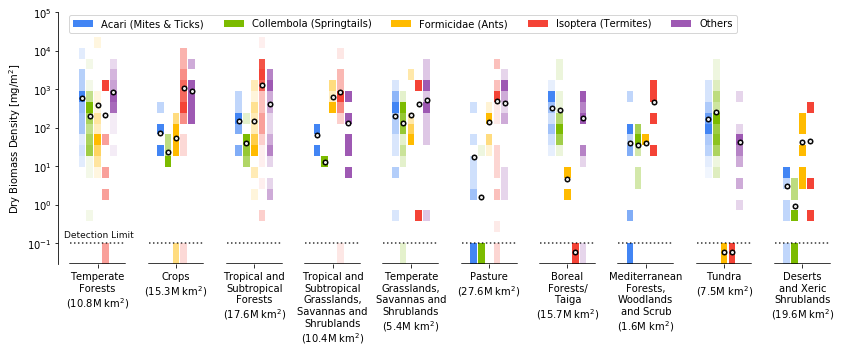

In [19]:
r = soil_site_data_mass_all.reset_index().rename(columns={'mass_G':'numerical value'}) #'numerical value' is the column being used later

#Sort according to biomes total mean biomass, in a descending order
sorter = soil_biome_means_G.reset_index().groupby('aggregated biome').sum().sort_values(by='Mean',ascending=False).index
sorterIndex = dict(zip(sorter, range(len(sorter))))
r['sorting_biomes'] = r['aggregated biome'].map(sorterIndex)
r.sort_values(['sorting_biomes'],ascending = True, inplace = True)
r.drop('sorting_biomes', 1, inplace = True)

original_biomes = r['aggregated biome'].unique()
transdict = {'Boreal Forests/Taiga': 'Boreal\nForests/\nTaiga\n(15.7M km$^2$)',
             'Crops':'Crops\n(15.3M km$^2$)',
             'Deserts and Xeric Shrublands':'Deserts\nand Xeric\nShrublands\n(19.6M km$^2$)',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean\nForests,\nWoodlands\nand Scrub\n(1.6M km$^2$)',
             'Pasture':'Pasture\n(27.6M km$^2$)',
           'Temperate Forests':'Temperate\nForests\n(10.8M km$^2$)',
           'Temperate Grasslands, Savannas and Shrublands':'Temperate\nGrasslands,\nSavannas and\nShrublands\n(5.4M km$^2$)',
           'Tropical and Subtropical Forests':'Tropical and\nSubtropical\nForests\n(17.6M km$^2$)',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands\n(10.4M km$^2$)',
           'Tundra':'Tundra\n(7.5M km$^2$)'
            }

print_biomes = [transdict[biome] for biome in original_biomes]
r4 = r.replace(to_replace=original_biomes,value=print_biomes)
r4 = r4.loc[r4['numerical value']>=0] ###

bins = np.logspace(-1,np.log10(r4['numerical value'].max()),20)
bins = np.insert(bins,0,-0.1) #add the point -0.1 to the beginning of the bins array
#bins = np.logspace(r4['numerical value'].min(),r4['numerical value'].max(),20)   
t = r4.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index()
y = t.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(np.max).reset_index()
t3 = t.merge(y,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon'])
t3['val'] = t3['numerical value_x']/t3['numerical value_y']


Isoptra = Isoptera_data.replace(to_replace=original_biomes,value=print_biomes)


fig,ax=plt.subplots(figsize=[12,5]) #[11,4])

fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
col_arr = ['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3']

def print_data(x):
    col_map = pd.Series(col_arr,index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
    ax.set_yscale('symlog',linthreshy=0.1)
    
    
def print_mean_median(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Mean = x['numerical value'].mean()
    SEM = x['numerical value'].sem()
    Y = (Mean, Mean - SEM , Mean + SEM)
    plt.scatter(x=xloc,y=Y[0],marker='.',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[1],marker='_',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[2],marker='_',c='k',s=40,zorder=3)
    
    
def print_mean_log(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = LogMean(x['numerical value'],kk = 1,scale = Scale)
    plt.scatter(x=xloc,y= Y[0],marker='o',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[1],marker='2',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[2],marker='1',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= (Y[0]+x['numerical value'].mean())/2,marker='4',c='m', alpha=1,s=40,zorder=4)
    

def print_combined_mean(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = calc_mean(x['numerical value'])+0.08
    plt.scatter(x=xloc,y= Y,marker='.' ,c='k', alpha=1,s=100,zorder=3)
    plt.scatter(x=xloc,y= Y,marker='.' ,c='#EBEBEB', alpha=1,s=15,zorder=3)    

def print_combined_errors(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y1 = calc_min(x['numerical value'])
    Y2 = calc_max(x['numerical value'])
    plt.scatter(x=xloc,y=Y1 ,marker='_',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y2 ,marker='_',c='k',s=40,zorder=3)
    
#Print fine average of Isoptera
def print_mean_Isoptera(x):
    fine_loc_Iso = 0.2;
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc_Iso
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='#EBEBEB', alpha=1,s=15,zorder=4)
    plt.scatter(x=xloc,y=x['Low estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['High estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)

    
    
    
#     if x['val'].values[0] >0:
#         plt.plot([xloc-0.17/2,xloc+0.17/2],[x['level_2'].values[0].right,x['level_2'].values[0].right],color='k',linewidth=0.7,alpha=1)
for i in range(0,2*len(r4['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[0.05,0.05],'k')   #plot lines for labels
#    plt.plot([i-0.7,i+0.7],[1.01e-2,1.01e-2],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:',alpha = 0.8)        #plot dotted lines for breaking points

ax = t3.groupby(['aggregated biome','aggregated taxon','level_2']).apply(print_data)
ax = plt.gca()
ax.set_xticks(range(0,2*len(r4['aggregated biome'].unique()),2))
ax.set_xticklabels(r4['aggregated biome'].unique())
ax.get_label()
ax.set_ylabel('Dry Biomass Density [mg/m$^2$]')
#plt.legend()
ax.set_ylim([0.05,1e5])
ax.set_xlim([-1,19])
legend_without_duplicate_labels(ax,(0.007,0.9)) #(0.98,0))
sb.despine(top=True, bottom=True, right=True)
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_median)##
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_log)##
#Isoptra.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_Isoptera)##
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_combined_errors)##
r4.groupby(['aggregated biome','aggregated taxon']).apply(print_combined_mean)##

ax.text(0.007, 0.135, 'Detection Limit', transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)

plt.tight_layout()




#plt.savefig('results/fig_mass_dens_all_G.svg',dpi=300) ##
plt.savefig('results/fig_mass_dens_all_G_DL.pdf',dpi=300) ##
#plt.savefig('results/fig_mass_dens_all_G.png',dpi=600) ##






9. Calculate the total population in soils

In [25]:
#soil_biome_Mean = soil_biome_means.Mean #take the combined mean per taxon and biome
soil_biome_Mean = soil_biome_means_G  #Change _G or _B for global or biome-level ind. mass, where applicable

##--Change termites means to carful estimates--
#Isoptera_data = pd.read_excel('data/IsopteraData.xlsx')
#Isoptera_data.set_index('aggregated biome' , inplace = True)
#soil_biome_Mean.Mean.Isoptera = Isoptera_data.loc[:,'Mid estimate']
#soil_biome_Mean.Min.Isoptera = np.minimum(Isoptera_data.loc[:,'Low estimate'], soil_biome_Mean.Min.Isoptera)# Isoptera_data.loc[:,'Low estimate']
#soil_biome_Mean.Max.Isoptera = np.maximum(Isoptera_data.loc[:,'High estimate'], soil_biome_Mean.Max.Isoptera)#Isoptera_data.loc[:,'High estimate']


biome_area = pd.read_csv('data/aggregated biomes data.csv') # biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum() #aggregate the biomes areas
soil_biome_Mean1 = soil_biome_Mean.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes to the means DF
soil_biome_Mean1.loc[:,'Total'] = (soil_biome_Mean1.loc[:,'Mean']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean1.loc[:,'Total_high'] = (soil_biome_Mean1.loc[:,'Max']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean1.loc[:,'Total_low'] = (soil_biome_Mean1.loc[:,'Min']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)

total_soil = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].sum()/1e15

print('total high estimate is: ' + "{:.0f}".format(total_soil['Total_high']) + ' Mt dry biomass in soils')
print('total mid estimate is: ' + "{:.0f}".format(total_soil['Total'] ) + ' Mt dry biomass in soils')
print('total low estimate is: ' + "{:.0f}".format(total_soil['Total_low'])  + ' Mt dry biomass in soils')


total high estimate is: 324 Mt dry biomass in soils
total mid estimate is: 161 Mt dry biomass in soils
total low estimate is: 78 Mt dry biomass in soils


In [26]:
soil_taxon_tot = soil_biome_Mean1.groupby('aggregated taxon')['Total_high','Total','Total_low'].sum()
print(soil_taxon_tot['Total_high']/soil_taxon_tot['Total'])
print(soil_taxon_tot['Total_low']/soil_taxon_tot['Total'])
print(soil_taxon_tot['Total']/1e15)
print(soil_taxon_tot['Total'].sum()/1e15)


aggregated taxon
Acari         1.663135
Collembola    2.073536
Formicidae    2.006354
Isoptera      2.200718
Other         1.910246
dtype: float64
aggregated taxon
Acari         0.661274
Collembola    0.528160
Formicidae    0.596668
Isoptera      0.339023
Other         0.557949
dtype: float64
aggregated taxon
Acari         18.622241
Collembola    10.604800
Formicidae    20.053331
Isoptera      64.293191
Other         46.977970
Name: Total, dtype: float64
160.55153278694783


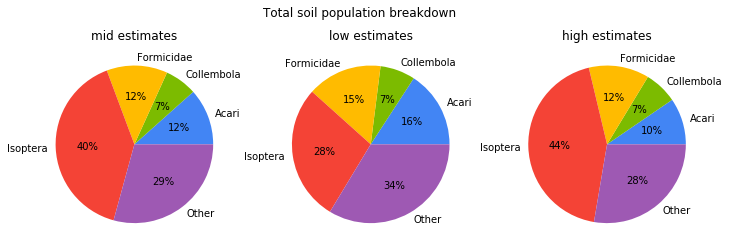

<Figure size 432x288 with 0 Axes>

In [27]:
Labels=['Acari','Collembola','Formicidae','Isoptera','Other']

fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=[12,4])
fig.suptitle('Total soil population breakdown')

ax1.pie(((soil_biome_Mean1.groupby('aggregated taxon').Total.sum())/total_soil['Total']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')
ax2.pie(((soil_biome_Mean1.groupby('aggregated taxon')['Total_low'].sum())/total_soil['Total_low']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')
ax3.pie(((soil_biome_Mean1.groupby('aggregated taxon')['Total_high'].sum())/total_soil['Total_high']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')

ax1.title.set_text('mid estimates')
ax2.title.set_text('low estimates')
ax3.title.set_text('high estimates')

plt.show()

plt.tight_layout()
#fig.savefig('results/fig2a_all.svg', dpi=300)
#fig.savefig('results/fig2a_all.pdf', dpi=300)
#(part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)


In [28]:
mg_m2 = (soil_biome_Mean1.groupby('aggregated taxon').Total.sum()/biome_area1.sum())
mg_ind = soil_ratio_filt_full.loc[:,'Total average (mg/ind)']
num_m2 = mg_m2 / mg_ind

#num_m2.sum()
biome_area1.sum()/1e14

1.31543

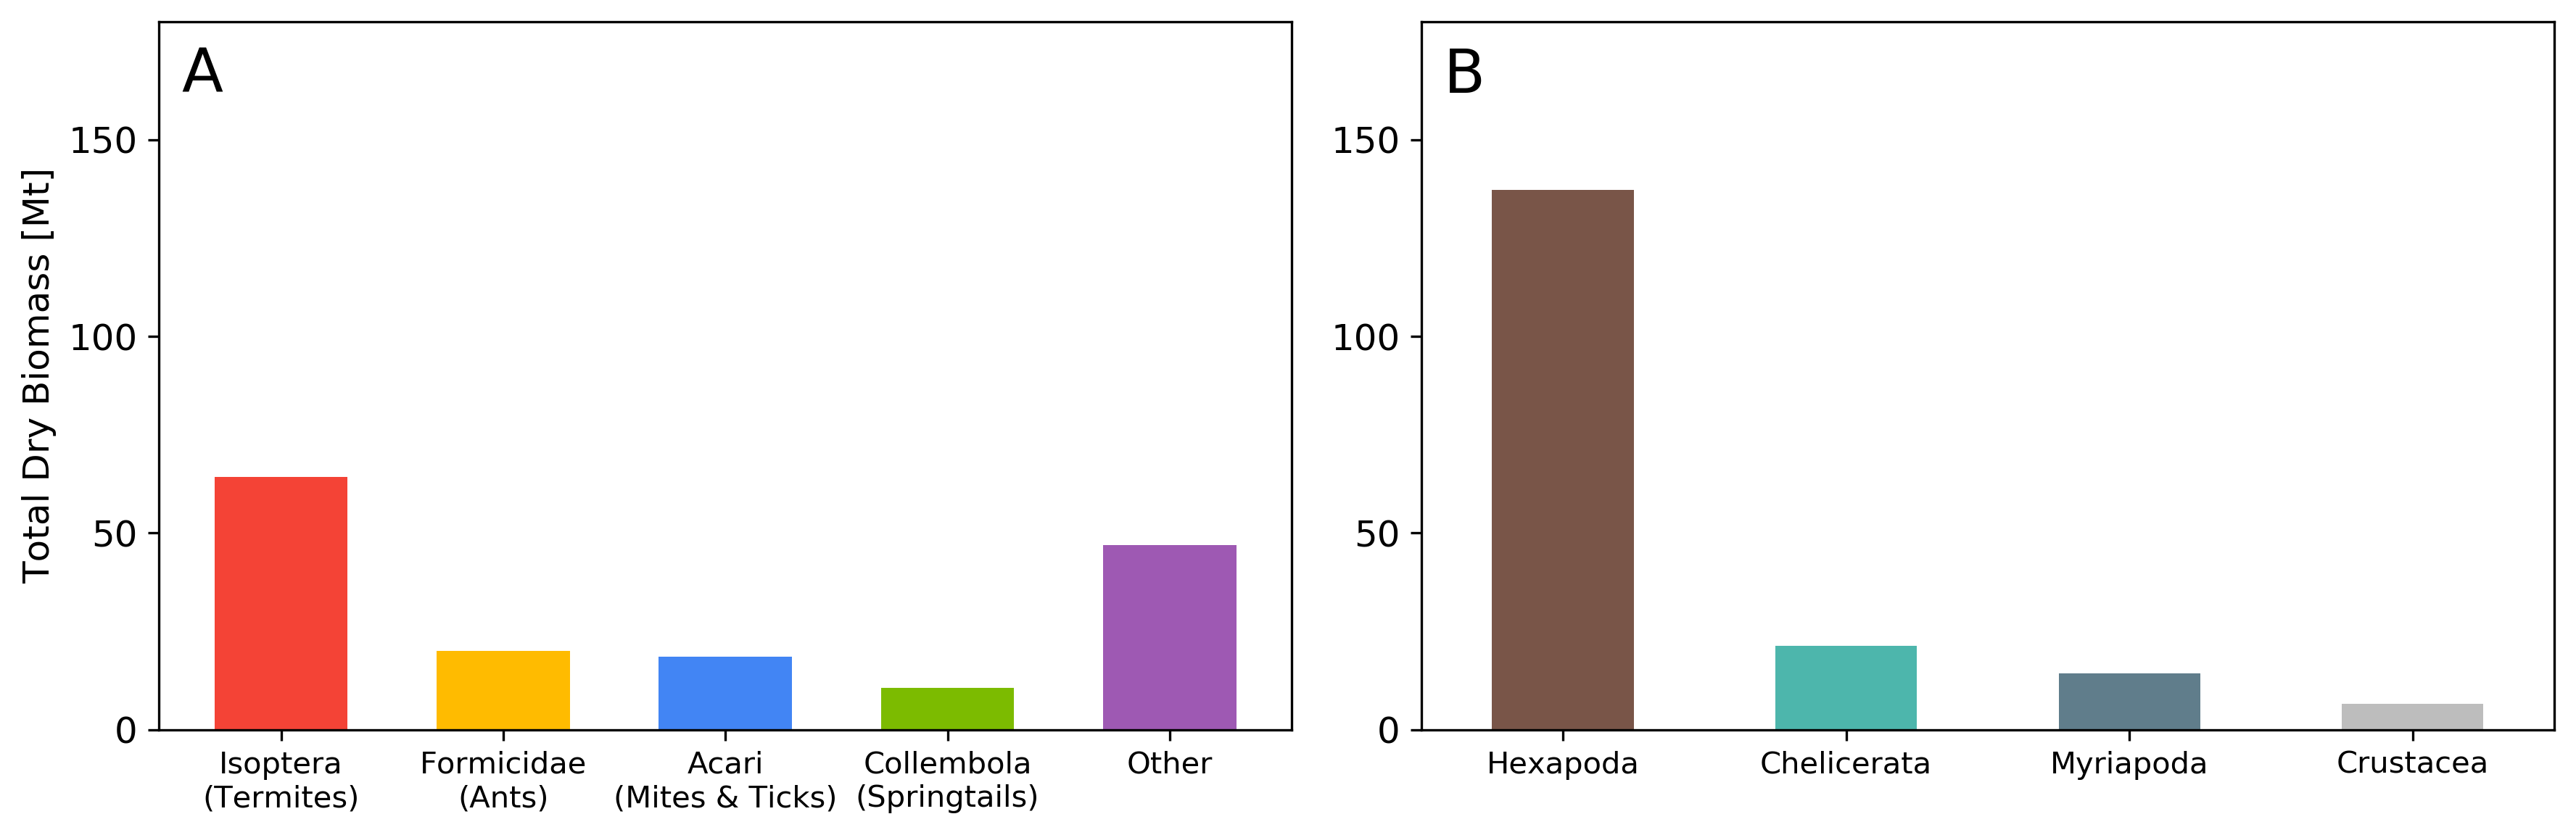

In [29]:
plt.rcParams.update({'font.size': 12}) #increase the font size here
plt.rc('text', usetex=False)


fig,ax1 = plt.subplots(1,2,figsize=[12,4],dpi=300)
ax1 = plt.subplot(1,2,1)
group_sum = (soil_biome_Mean1.groupby('aggregated taxon').Total.sum()/1e15)
group_colors = pd.Series(col_arr,index = group_sum.index)
new_index = ['Isoptera','Formicidae','Acari','Collembola','Other']
group_sum = group_sum.reindex(new_index)
group_colors = group_colors.reindex(new_index)
#group_sum.index = ['Isoptera\n(Termites)','Formicidae\n(Ants)','Acari\n(Mites & Ticks)','Collembola\n(Springtails)','Other']
group_sum.index = ['Isoptera\n(Termites)','Formicidae\n(Ants)','Acari\n(Mites & Ticks)','Collembola\n(Springtails)','Other']

group_colors.index = group_sum.index
#group_sum.sort_values(ascending=False,inplace=True)
#group_sum.sort_values(ascending=False).plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax)
group_sum.plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax1)
ax1.set_ylabel('Total Dry Biomass [Mt]')
plt.xticks(fontsize=10)

# (part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)
ax2 = plt.subplot(1,2,2)
subphyla_sum = pd.read_csv('results/subphyla_sum.csv') #subphyla_sum = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/1e15)
subphyla_sum.index = subphyla_sum.iloc[:,0]
del subphyla_sum.index.name
subphyla_sum = subphyla_sum.iloc[:,1]
subphyla_colors = pd.Series(['#795548', '#4db6ac','#607d8b','#bdbdbd'],index = subphyla_sum.index)
#subphyla_sum.sort_values(ascending=False,inplace=True)
subphyla_sum.plot.bar(width = 0.5,color=subphyla_colors.loc[subphyla_sum.index],ax=ax2,rot=0)
plt.xticks(fontsize=10)

ax1.set_ylim([0,180])
ax2.set_ylim([0,180])
ax1.set(yticks=np.arange(0,200,50))
ax2.set(yticks=np.arange(0,200,50))


#ax.set_ylim([0,0.21])
#ax2.set_ylim([0,0.21])
#ax.set(yticks=np.arange(0,0.25,0.05))
#ax2.set(yticks=np.arange(0,0.25,0.05))
# ax.set_ylabel('Biomass [Gt]')
# plt.savefig('results/fig2b.svg', dpi=300)
#ax.text(-1,160,'A',fontdict={'size':20})
#ax2.text(-1,160,'B',fontdict={'size':20})
ax1.text(0.02,0.9,'A',fontdict={'size':20},transform = ax1.transAxes)
ax2.text(0.02,0.9,'B',fontdict={'size':20},transform = ax2.transAxes)
plt.tight_layout()

#plt.savefig('results/fig2.svg', dpi=300)
#plt.savefig('results/fig2.pdf', dpi=300)##
#plt.savefig('results/fig2.png', dpi=300)##

# plt.savefig('results/fig2b.svg', dpi=300)
# ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value)

plt.rcParams.update({'font.size': 10}) #decrease back the font size here

In [30]:
subphyla_sum = pd.read_csv('results/subphyla_sum.csv') #subphyla_sum = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/1e15)
subphyla_sum.index = subphyla_sum.iloc[:,0]
subphyla_sum = subphyla_sum.iloc[:,1]
subphyla_sum

Unnamed: 0
Hexapoda       137.210509
Chelicerata     21.389202
Myriapoda       14.300360
Crustacea        6.602141
Name: 0, dtype: float64

12. Calculate the overall total population, assuming places with no data has no individuals

13. Calculate and plot the total population per aggregated biome 

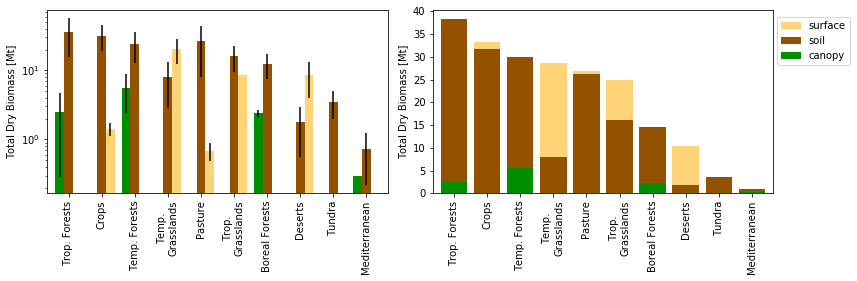

In [31]:
#The total soil biomass calculated here (Gt), using both population and biomass data
Soil_mass = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].groupby('aggregated biome').sum()/1e15
Soil_mass=Soil_mass.reset_index()
Soil_mass.insert(0, 'env', 'soil',True)

#Read the total biomass of canopy and surface and replace the soil biomass to the current estimation 
biome_totals_mass = pd.read_csv('results/table_biome_totals_mass.csv')
biome_totals_mass.loc[biome_totals_mass['env']=='soil'] = Soil_mass

biome_totals_pop = pd.read_csv('results/table_biome_totals_pop.csv')

def sort_by_index(x,sorted_indx):
    sorterIndex = dict(zip(sorted_indx, range(len(sorted_indx))))
    x['sorting_biomes'] = x.index.map(sorterIndex)
    x.sort_values(['sorting_biomes'],ascending = True, inplace = True)
    x.drop('sorting_biomes', 1, inplace = True)
    return x

def data4tot_plot(x):
    #rename labels for plot
    original_biomes = x['aggregated biome']
    transdict = {'Boreal Forests/Taiga': 'Boreal Forests',
             'Crops':'Crops',
             'Deserts and Xeric Shrublands':'Deserts',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean',
             'Pasture':'Pasture',
           'Temperate Forests':'Temp. Forests',
           'Temperate Grasslands, Savannas and Shrublands':'Temp.\nGrasslands',
           'Tropical and Subtropical Forests':'Trop. Forests',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Trop.\nGrasslands',
           'Tundra':'Tundra'
            }
    print_biomes = [transdict[biome] for biome in original_biomes]    
    x['aggregated biome'] = print_biomes
    
    #total values
    x_tot = x.reset_index().pivot(index = 'aggregated biome' , columns = 'env', values='Total')    
    
    #sort by descending values
    sorter = x_tot.sum(axis=1).sort_values(ascending=False).index
    x_tot = sort_by_index(x_tot ,sorter )
    
    x['err_low'] = (x.loc[:,'Total']-x.loc[:,'Total_low'])
    x['err_high'] = (x.loc[:,'Total_high']-x.loc[:,'Total'])
    
    err_l = x.pivot(index = 'aggregated biome' , columns = 'env', values='err_low' ) 
    err_l = sort_by_index(err_l,x_tot.index)
    err_h = x.pivot(index = 'aggregated biome' , columns = 'env', values= 'err_high')
    err_h = sort_by_index(err_l,x_tot.index)
    
    err = []
    for col in err_l:  # Iterate over bar groups (represented as columns)
        err.append([err_l[col].values, err_h[col].values])    
        
    return x_tot , err


mass_tots, err_m = data4tot_plot(biome_totals_mass)
pop_tots, err_p= data4tot_plot(biome_totals_pop)


fig = plt.subplots(figsize=[12,4])
ax = plt.subplot(1,2,1)
mass_tots.plot.bar(yerr=err_m ,width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax,logy=True,stacked=False,rot=90,legend=False)
ax.set_ylabel('Total Dry Biomass [Mt]')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
#ax.legend(loc = [1.01,0.7])
#ax.ticks

ax = plt.subplot(1,2,2)
mass_tots.plot.bar(width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax,logy=False,stacked=True)
ax.set_ylabel('Total Dry Biomass [Mt]')
#ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[2],handles[1],handles[0]],[labels[2],labels[1],labels[0]],loc = [1.01,0.7])

plt.tight_layout()

#plt.savefig('results/fig_pop_biome_totsig_.svg', dpi=300)
#plt.savefig('results/fig_pop_biome_tots.pdf', dpi=300)##

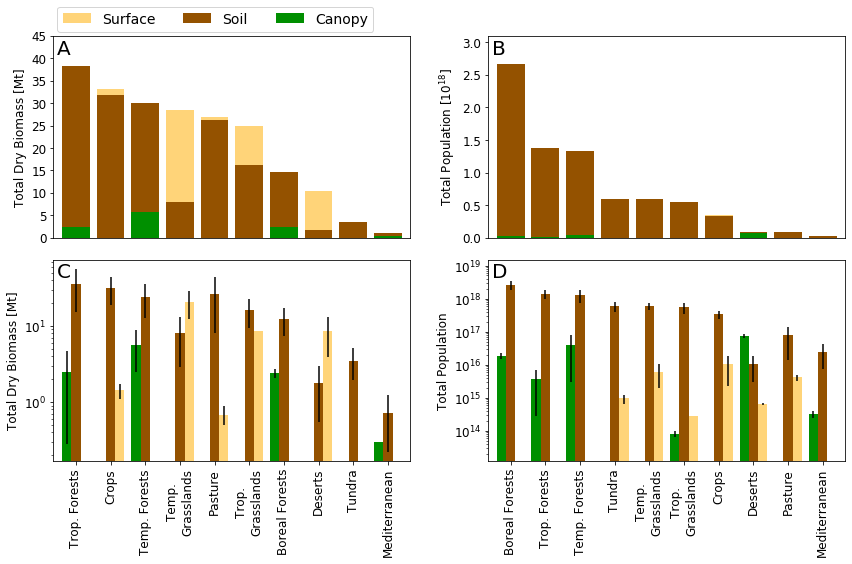

In [32]:
plt.rcParams.update({'font.size': 12}) #increase the font size here

fig = plt.subplots(figsize=[12,8])


ax1 = plt.subplot(2,2,1)
mass_tots.plot.bar(width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax1,logy=False,stacked=True)
ax1.set_ylabel('Total Dry Biomass [Mt]')
#ax.xaxis.set_ticklabels(ticklabels)
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
ax1.set_ylim([0,45])
handles, labels = ax1.get_legend_handles_labels()

transdict = {'surface': 'Surface',
             'soil': 'Soil',
             'canopy': 'Canopy'
            }
Labels = [transdict[env] for env in labels]

ax1.legend([handles[2],handles[1],handles[0]],[Labels[2],Labels[1],Labels[0]],loc = [0.01,1.02],ncol=3,fontsize=14)
#ax1.legend([handles[2],handles[1],handles[0]],['Surface','Soil','Canopy'],loc = [0.01,1.02],ncol=3,fontsize=12)
ax1.text(0.01,0.91,'A',fontdict={'size':20},transform = ax1.transAxes)

ax2 = plt.subplot(2,2,2)
(pop_tots/1e18).plot.bar(width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax2,logy=False,stacked=True)
ax2.set_ylabel('Total Population [$10^{18}$]')
#ax.xaxis.set_ticklabels(ticklabels)
x_axis = ax2.axes.get_xaxis()
x_axis.set_visible(False)
ax2.set_ylim([0,3.1])
ax2.get_legend().remove()
ax2.text(0.01,0.91,'B',fontdict={'size':20},transform = ax2.transAxes)


ax3 = plt.subplot(2,2,3)
mass_tots.plot.bar(yerr=err_m ,width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax3,logy=True,stacked=False,rot=90,legend=False)
ax3.set_ylabel('Total Dry Biomass [Mt]')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax3.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
#ax.legend(loc = [1.01,0.7])
#ax.ticks
ax3.text(0.01,0.91,'C',fontdict={'size':20},transform = ax3.transAxes)

ax4 = plt.subplot(2,2,4)
pop_tots.plot.bar(yerr=err_p ,width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax4,logy=True,stacked=False,rot=90,legend=False)
ax4.set_ylabel('Total Population')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax4.xaxis.label.set_visible(False)
ax4.set_ylim([1.2e13,1.5e19])
#ax.legend(loc = [1.01,0.7])
#ax.ticks
ax4.text(0.01,0.91,'D',fontdict={'size':20},transform = ax4.transAxes)

plt.tight_layout()

plt.rcParams.update({'font.size': 10}) #increase the font size here

#plt.savefig('results/fig_tots.svg', dpi=300)
#plt.savefig('results/fig_tots.pdf', dpi=300)##
#plt.savefig('results/fig_tots.png', dpi=300)##